# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 9
### <center> Yoshihiro Shirai

# Ensemble Learning and Random Forests

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 7: Ensemble Learning, bagging and pasting, random forests, AdaBoost, gradient boosting.

#  0. Overview of the lecture

- We discuss an ensemble learning method called voting classifiers. Ensemble learning is a way of aggregating different ML methods to obtain a more powerful method.

- We continue our discussion of ensemble learning methods.

- We first discuss bagging and pasting which are methods to create ensembles by sampling from the training set.

- We then discuss random forests, which are a special type of bagging with decision trees as the base estimator.

- Lastly, we discuss two boosting methods, namely, AdaBoost and gradient boosting. These are sequential methods for creating an ensemble of predictors, where new predictors improve upon the previous ones.

# 1. Ensemble Learning

- Suppose that you have a large number of models for an identical task.

- It is usually the case that by "aggregating" the results of these models, we get a model that is superior to the best of the original models.

- A set of predictors is called an ensemble. Creating a new model based on aggregating an ensemble is called ensemble learning.

# 1.1. Voting classifiers

- Voting classifiers are the simplest ensemble learning method.

- Suppose that you have an ensemble of classifiers.

- You train each classifier on the training set.

- Now, suppose that you want to predict the class of a new observation. It is probable that different classifiers predict different labels.

- A **hard voting** classifier assigns the class that gets the **most votes** in the ensemble.

- Assume that each classifier predicts the probability of each class (instead of just reporting a decision function). A **soft voting** classifier first finds the average probability of each class across the ensemble, and then predicts the class as the class with the highest average probability.

- Let us see why voting classifiers are better than individual classifiers in the ensemble.

- Assume that you have an ensemble of $N$ classifiers. Assume there are 2 classes. Assume, also, that the predictions of classifiers are independent of each other. This is not a realistic assumption in reality. Why?

- Suppose that the probability that each classifier is correct is $p$. Let $Z_n=1$ if the n-th classifier is correct, and $Z_n$=0$ otherwise. 

- By the assumption, the total number of correct votes, $Z=\sum_{n=1}^N Z_n$ is $\text{Binomial}(N,p)$. Thus, the (hard) voting classifier is correct if $Z> \frac{N}{2}$.

- Assume that $p=0.51$, (ie. each classifier is barely better than a random classifier).

- Let us calculate the accuracy of the voting classifier for different sizes of the ensemble

In [1]:
from scipy.stats import binom
p = 0.51
for N in [100, 500, 1000]:
    print("N={}, P(Z>N/2)={:.3}".format(N, 1-binom.cdf(N/2, N, p)))

N=100, P(Z>N/2)=0.54
N=500, P(Z>N/2)=0.656
N=1000, P(Z>N/2)=0.726


- If we have 1000 classifiers, the accuracy of the voting classifier is about 72%, which is much better than the individual accuracy of the classifiers in the ensemble.

- In reality, the classifiers in the ensemble will not produce independent predictions (they are not independent because they are trained over the same training set). The more diverse they are (less dependent), the higher the performance of the voting classifier.

- Let us evaluate the performance of a hard voting classifier over the make_moons dataset.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

- The ensemble consists of the following three classifiers.

- To create a voting classifier, we can use the `sklearn.ensemble.VotingClassifier` class

In [3]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

- Let us compare the accuracy of the classifiers over the test set. The hard voting classifier has a small improvement over the best classifier.

In [4]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))
print("hard voting", "=", voting_clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896
hard voting = 0.912


- Next, let us try a soft voting classifier.

- All the classifiers in the ensemble must have a `.predict_proba()` method. So, we need to pass the `probability=True` argument to the `SVC` classifier.

In [5]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

- The soft voting classifier has even a better performance over the best classifier in the ensemble.

In [6]:
print("soft voting", "=", voting_clf.score(X_test, y_test))

soft voting = 0.92


# 2. Bagging and pasting

- As we have discussed, ensemble learning methods provide the most benefit when the predictors in the ensemble are independent. Since independence is hard to achieve using the same training set, our goal is to make the predictors as diverse as possible.

- One way to promote diversity, is to use very different training algorithms.

- Another way, is to use different training sets. Specifically, we "create" different training sets based on the original training set, and train the same algorithm using these different training sets. The resulting predictors will be used as the ensemble.

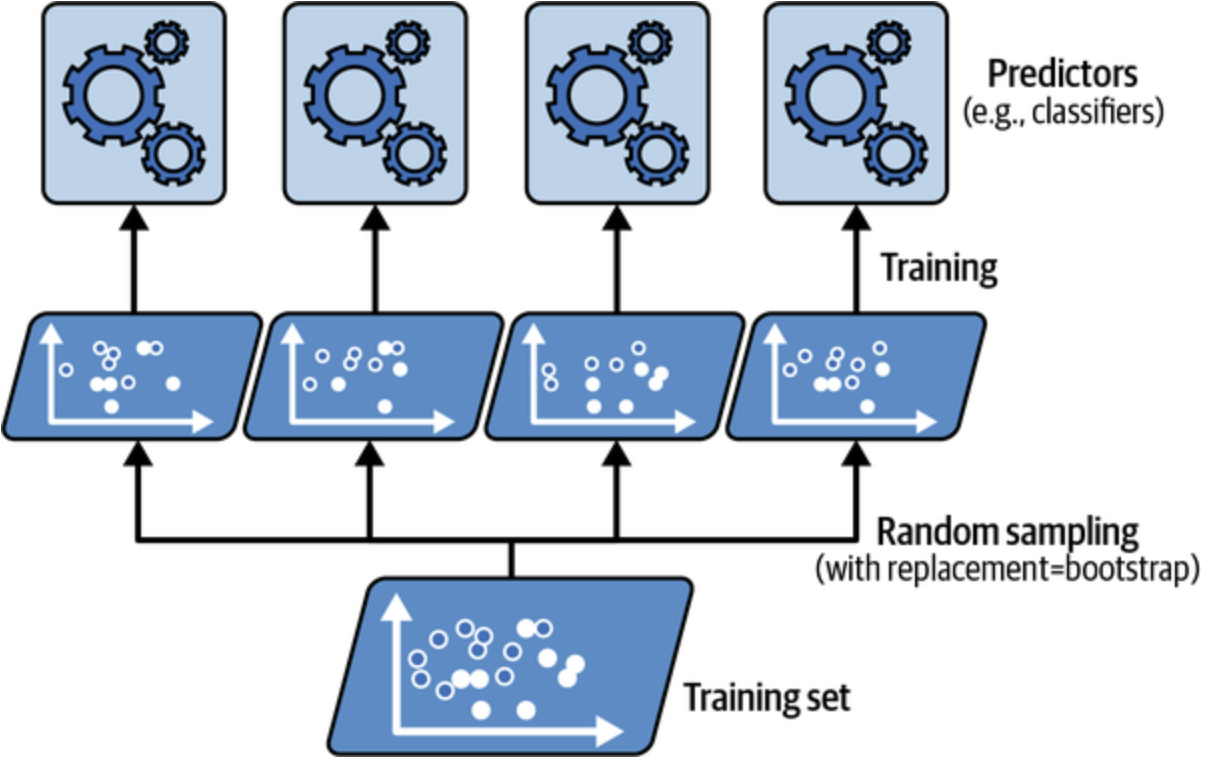

In [7]:
from IPython.display import display, Image
Image("Figs/bagging_pasting.png",width=600)

- Note that each predictor in the ensemble is more biased than the original predictor (which is trained on the whole data set). But, if done properly, the ensemble learning predictor will have similar bias and less variance.

- Our main decision is how to create the training sets.

- Let $N$ be the number of observations in the (original) training set. For each predictor in the ensemble, we can:
    
    (a) Randomly choose $m<N$ number of observations from the training set **without replacement**. In this case, the resulting training sets will be a subset of the original training set.
    
    (b) Randomly choose $m$ number of observations from the training set **with replacement**. In this case, we can have $m\geq N$. Note that the resulting training set may have duplicate instances from the original training set.

- The ensemble learning method based on (a) is called **pasting**. The one based on (b) is called **bagging** (short for bootstrap aggregating).

- After creating the ensemble (either by bagging or by pasting), we can obtain ensemble predictions by aggregation. For a regression task, we can take the average of the predictions in the ensemble. For classification, we can take the most voted class (hard voting) or the class with the highest average probability (soft voting).

- Bagging and pasting work particularly well for unstable predictors. These are learning algorithms that are sensitive to small changes in the training set. Decision trees are one example. As we will see, neural networks are another example.

- Note that both training and prediction in bagging and pasting can be done in parallel. This is the main reason for the popularity of these ensemble learning methods.

- Let us illustrate bagging and pasting using the make_moons dataset.

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

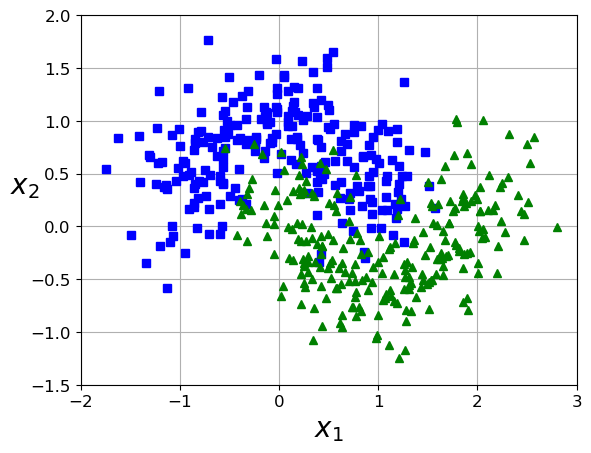

In [9]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.grid(True, which='both')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.axis([-2, 3, -1.5, 2])
plt.show()

- A single decision tree achieves 82% accuracy.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
ypred_tree = tree.predict(X_test)
accuracy_score(y_test, ypred_tree)

0.82

- We can use the `sklearn.ensemble.BaggingClassifier` class to obtain and ensemble with bagging (`bootstrap=True`) or pasting (`bootstrap=False`).

- `n_estimators` is the number of predictors in the ensemble.

- `max_samples` determines the number of observations in the subsamples. If it is an integer $n$, the subsamples will have $n$ observations. It can also be a fraction  $p\in (0,1)$,, in which case the subsamples will have $p\times N$ observations ($N$ is the size of the training set.

- `n_jobs` determines how many cores to use in parallel computing. If it is set to $−1$,, then all the available cores will be used.

- The pasting (respectively, bagging) classifier with 500 trees achieves 91% (respectively, 90%) accuracy on the test set.

In [11]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(tree, n_estimators=500,
                        n_jobs=-1, random_state=42)

bag.set_params(bootstrap=False, max_samples=100).fit(X_train,y_train)
ypred = bag.predict(X_test)
accuracy_score(y_test, ypred)

0.91

In [12]:
bag.set_params(bootstrap=True, max_samples=0.25, n_estimators=500).fit(X_train,y_train)
accuracy_score(y_test, bag.predict(X_test))

0.9

- Let us compare the decision boundaries of the decision tree and the bagging predictors.

In [13]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff','#a0faa0'])
x0, x1 = np.meshgrid(np.linspace(-2, 3, 200).reshape(-1, 1),
                     np.linspace(-1.5, 2, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

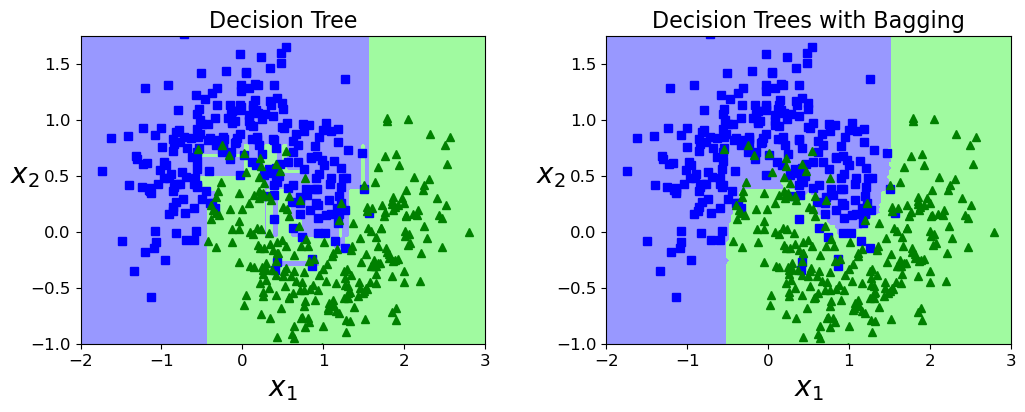

In [14]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
models = [tree, bag]
model_names = ['Decision Tree', "Decision Trees with Bagging"]
subplots=[121,122]
for idx, model in enumerate(models):
    model.fit(X, y)
    ypred = model.predict(X_new)
    zz = ypred.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.title(model_names[idx], fontsize=16)
    plt.axis([-2, 3, -1, 1.75])
plt.show()

# 2.1. Out-of-bag evaluation

- Bagging usually results in a better outcome than pasting, since the subsamples created with replacement have more diversity than the one created without replacement. This benefit, however, is not guaranteed. To be certain, one must use cross-validation to check which approach is better.

- **Out-of-bag** (or "oob" for short) evaluation is another reason one may want to use bagging over pasting. Oob evaluation is a type of cross-validation that can be conducted **during training** a bagging predictor.

- When we re-sample with replacement, we may have duplicate instances of some observation while other observations are not selected at all.

- The observations that are not selected are called out-of-bag (oob) observations.

- Let us assume that we have a sample $S=\{(\mathbf{x}_1,y_1), \dots, (\mathbf{x}_N,y_N)\}$

- We randomly choose $m$ observations with replacement. Let $S'=\{(\mathbf{x}'_1,y'_1), \dots, (\mathbf{x}'_m,y'_m)\}$ be the new sample.

- On average, what proportion of the observations are oob? In other words, what is the expected proportion of instances in $S$ that do not appear in $S'$?

- Let $Z_n$ be the indicator of the event that $(X_n,y_n)$ is oob. That is, $Z_n=1$ if the $n$-th sample is not selected. If $(X_n,y_n)$ is in $S'$, then we set $Z_n=0$.

- $Z:=\sum_{n=1}^N Z_n$ is the total number of oob instances. We also have:
$$\begin{align*}
  \mathbb{P}(Z_n=1) = \left(1-\frac{1}{N}\right)^m
\end{align*}$$

- Therefore,
$$\begin{align*}
    \mathbb{E}(Z) = \sum_{n=1}^N \mathbb{E}(Z_n) = \sum_{n=1}^N \mathbb{P}(Z_n) = N\left(1-\frac{1}{N}\right)^m
\end{align*}$$

- Finally, we obtain that the expected proportion of oob observations is
$$\begin{align*}
    \mathbb{E}\left(\frac{Z}{N}\right) = \left(1-\frac{1}{N}\right)^m
\end{align*}$$

- If we re-sample $\alpha$ proportion of the training set (i.e. <code>max_samples</code>$=\alpha$), then we have
$$\begin{align*}
    \mathbb{E}\left(\frac{Z}{N}\right) = \left(1-\frac{1}{N}\right)^{\alpha\,N}
\end{align*}$$

- In particular, note that
$$\begin{align*}
    \lim_{N\to +\infty}\mathbb{E}\left(\frac{Z}{N}\right) = e^{-\alpha}
\end{align*}$$

- For example, if we re-sample the whole training set with replacement (i.e. $\alpha=1$) then, on average, $e^{-1}\approx 37$% of the instances will not be selected. Note, however, that if we re-sample 10 times, then the oob instances will be different in the resulting 10 training sets.

- The bottom line is, no matter how large the re-sampled training sets are, we always end up with a significant portion of unused instances for each predictor.

- Why not use the oob instances to report the out-of-sample performance of each predictor in the ensemble after we trained it?

- If we do so, we will get a set of out-of-sample scores, one score for each predictor in the ensemble.

- **Oob evaluation score** is the average of these out-of-sample scores. It comes (almost) free, there is no need to do a K-fold cross validation.

- BaggingClassifier class provides the argument `oob_score=True` for oob evaluation (it only works for bagging, that is `bootstrap=True`)

- Once trained, you can access the oob scores by ~.oob_score_` property.

In [15]:
bag.set_params(bootstrap=True,
               max_samples=.25,
               oob_score=True).fit(X_train,y_train)
bag.oob_score_

0.915

- If we directly use 10-fold cross validation, we get an average accuracy that is very near the oob score.

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(bag, X_train, y_train, cv=10, scoring="accuracy").mean()

0.9200000000000002

- The test score is also quite close.

In [17]:
bag.set_params(bootstrap=True, max_samples=.25).fit(X_train,y_train)
accuracy_score(y_test, bag.predict(X_test))

0.9

- The bottom line is to use oob evaluation instead of K-fold cross validation.

- You can also get the value of the decision function for all the instances in the training set by using the ``.oob_decision_function_``

In [18]:
bag.oob_decision_function_[:10]

array([[0.98670213, 0.01329787],
       [0.01066667, 0.98933333],
       [0.08974359, 0.91025641],
       [0.94670051, 0.05329949],
       [0.95886889, 0.04113111],
       [0.98994975, 0.01005025],
       [0.87002653, 0.12997347],
       [0.82479784, 0.17520216],
       [0.31524548, 0.68475452],
       [0.03768844, 0.96231156]])

# 2.2. Random patches and random subspaces

- Instead of (or in addition to) selecting random observations to make new training sets, we may select random features to create new trainings sets.

- Specifically, instead of using $(\mathbb{X}_n, y_n)$, we can use $(\mathbb{X}'_n, y_n)$ where $\mathbb{X}'_n$ is a vector containing a random selection of the features in $\mathbb{X}_n$. As in bagging and pasting, the re-sampling can be achieved with or without replacement.

- This idea works particularly well for the case where there are a large number of features, for example, in the MNIST classification example.

- An ensemble learning method that involves both sampling observations and features is called a **random patches** method

- Sampling only features but using the whole training set is called a **random subspaces** method.

- `sklearn.ensemble.BaggingClassifier` class provides the argument max_features to determine the number (or fraction) of features to use when training individual estimators and the `bootstrap_features` to determine if sampling features is to be conducted with replacement (`True`) or without replacement (`False`).

- Several of these hyperparameters for the `sklearn.ensemble.BaggingClassifier` class are also available in the random forest class. Try experimenting with them.

# 3. Random forests

- A **random forest** is an ensemble of decision trees trained (usually) with bagging and where the training set of each tree has the same size as the training set (`max_samples`$=N$).

- Random forests training algorithms usually introduce extra randomness when growing trees.

- For example, by default, when branching a node, only a random subset of features are evaluated instead of considering all possible features.

- This will diversify the trees which (usually) reduces the variance of the random forest predictor while keeping the bias unchanged.

- For classification, predictions are made by averaging the probability of each class over all the trees, and choosing the class with the highest probability.

- For regression, the average prediction over all the trees is used.

- In a variation of random forests, called **extra-trees** (short for extremely randomized trees) ensemble, we take randomness a step further.

- When splitting a node, the algorithm assigns a random threshold instead of finding the best threshold for a feature.

- As a result:
    - The grown trees have a lot of variations.
    - It is much faster to grow a tree, since most of the effort is in finding the best threshold.

- It is not clear in advance if an extra-trees ensemble performs better than a regular random forest. One should perform cross-validation to find out. Remember that you have oob evaluation for both.

- The `sklearn.ensemble.RandomForestClassifier` class implements random forests. It has most of the arguments of the `sklearn.tree.DecisionTreeClassifier` class (for growing the trees) and `sklearn.ensemble.BaggingClassifier` (for creating the ensemble).

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500,
                                max_leaf_nodes=16,
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1, random_state=42)
%time forest.fit(X_train, y_train)
forest.oob_score_

Wall time: 470 ms


0.91

In [20]:
accuracy_score(y_test, forest.predict(X_test))

0.89

- The `sklearn.ensemble.ExtraTreesClassifier` implements the extra-trees ensemble method. It has a similar interface as the `RandomForestClassifier` class.

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
extraforest = ExtraTreesClassifier(n_estimators=500,
                                max_leaf_nodes=16,
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1, random_state=42)
%time extraforest.fit(X_train, y_train)
extraforest.oob_score_

Wall time: 451 ms


0.9

In [22]:
accuracy_score(y_test, extraforest.predict(X_test))

0.9

# 3.1. Feature importance

- Another nice feature of random forests is that they provide a simple and transparent measure for relative importance of features.

- To find this **feature importance** measure for a feature, we first find the weighted average of the reduction in impurity for all the nodes that used that feature, where the node's weight is its sample size. Then average this across all trees in the forest.

- The weight is the number of observations in the node corresponding to each branch.

- After finding the average reductions for all the features, we scale them so that they sum to 1.

- We can access feature importances using the ``.feature_importance_`` property of a trained random forest (`RandomForestClassifier` or `ExtraTreesClassifier`)


In [23]:
forest.feature_importances_

array([0.4353328, 0.5646672])

In [24]:
extraforest.feature_importances_

array([0.42990535, 0.57009465])

- Let us see the feature importances in the iris dataset. As you can see, the petal dimensions are more important.

In [25]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


- Feature importances can be very useful when there is a large number of features. For example, let us train a random forest on the MNIST dataset.

In [27]:
from sklearn.datasets import fetch_openml
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, cache=True)

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

RandomForestClassifier(random_state=42)

- Now that we have trained a random forest, we can look at the feature importances to see which pixels in the image are important for identifying the digit.

- It is best to visualize the feature importances, instead of showing the numerical values.

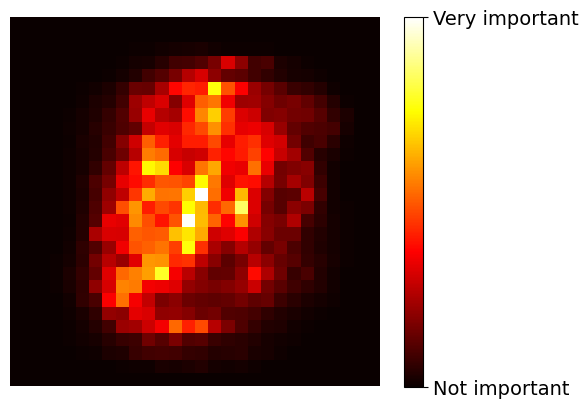

In [29]:
heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

# 4. AdaBoost
- A boosting method is any method that can turn several weak learning algorithms into a strong learning algorithm. The general idea of boosting is to **sequentially** train predictors, each predictor improving the previous one.

- The two most common boosting methods are **AdaBoost** (short for adaptive boosting) and **gradient boosting**.

- AdaBoost sequentially adds predictors to an ensemble.

- Each subsequent predictor **pays more attention** to the observations that the previous predictor has not fitted well.

- Once the ensemble reaches a predetermined size (or a perfect predictor is found), AdaBoost builds a predictor from the ensemble. In doing so, it assigns a weight to each predictor based on how good they fit the training set.

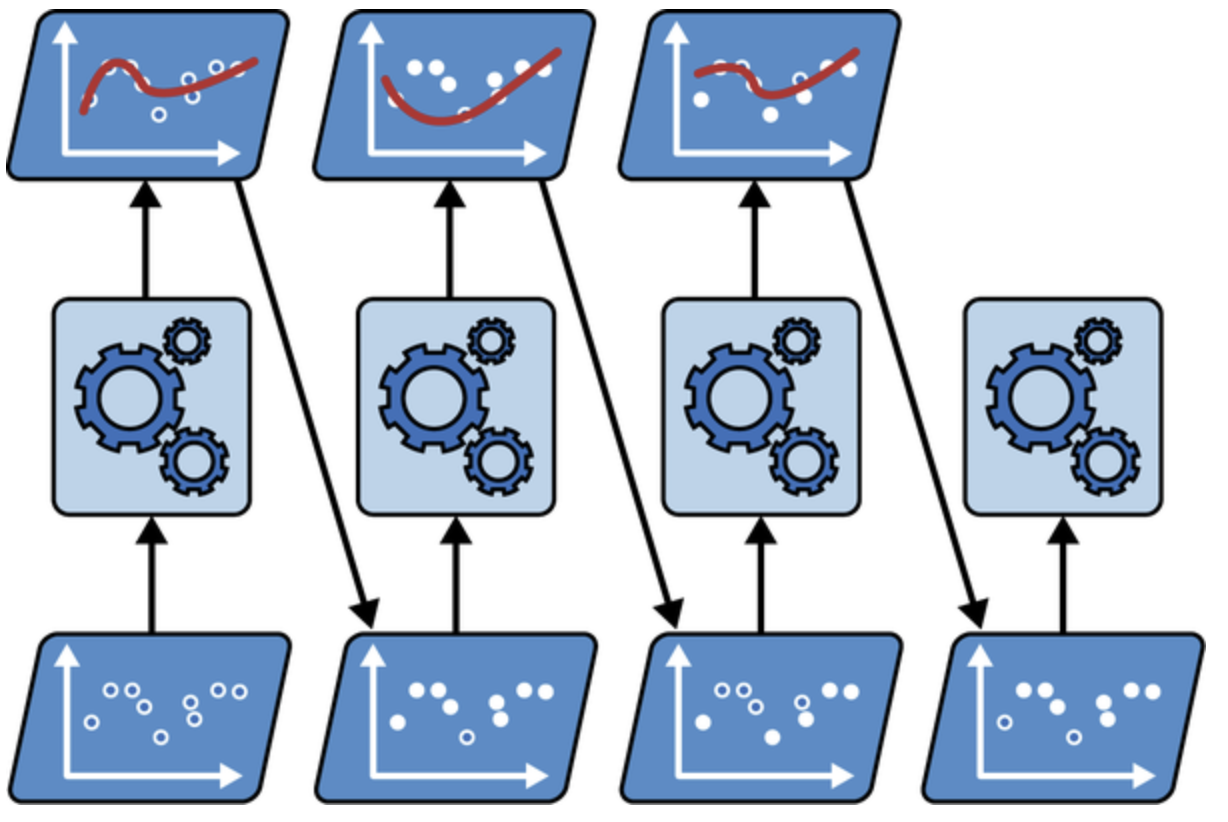

In [30]:
from IPython.display import display, Image
Image("Figs/Adaboost.png",width=600)

- The Adaboost algorithm (for binary classification) is as follows:
    
    - Consider a training set $S=\{(\mathbf{x}_n, y_n)\}_{n=1}^N$. We initially assign the weight $w_n^{(1)}=\frac{1}{N}$ to the $n$-th observation.
    
    - We iterate the following loop. In iteration $k$
        - <strong>Step 1:</strong> Train the $k$-th predictor using the base learning algorithm on $S$ with observation weights $(w_1^{(k)},\dots,w_N^{(k)})$. Let $\hat{y}_n^{(k)}$ be the predicted value of $y_n$ using this predictor.
        - <strong>Step 2:</strong> Define the <strong>error rate</strong> $r_k$ and the <strong>weight</strong> $\alpha_k$ of the $k$-th predictor by
            $$\begin{align*}
            r_k := \frac{\sum_{n=1}^N w_n^{(k)} \mathbb{1}_{y_n\ne\hat{y}_n^k}}{\sum_{n=1}^N w_n^{(k)}},\quad\qquad
            \alpha_k := \eta \log\left(\frac{1-r_k}{r_k}\right)
            \end{align*}$$ 
            - $\eta>0$ is the learning rate hyperparameter
            - For a completely random classifier $\alpha_k=0$. A classifier that makes more accurate (respectively, less accurate) prediction than a purely random classifier has a positive (respectively, negative) $\alpha_k$.
        - <strong>Step 3:</strong> Update the observation weights:
            $$\begin{align*}
            \tilde{w}_n^{(k+1)}:=
            \begin{cases}
                w_n^{(k)};&\quad y_n = \hat{y}_n^{(k)},\\\displaystyle
                w_n^{(k)} e^{\alpha_k};&\quad y_n \ne \hat{y}_n^{(k)},\\
            \end{cases}
            \quad\qquad
            w_n^{k} = \frac{\tilde{w}_n^{(k+1)}}{\sum_{\ell=1}^N \tilde{w}_\ell^{(k+1)}}.
            \end{align*}$$

- We iterate on Steps 1-3 until we create $K$ (a hyperparameter) predictors, or we find a perfect predictor (i.e. $r_k=0$ or $\alpha_k$ is larger than a constant)

- Once we have the ensemble of predictors, we can make new prediction like we did with bagging, with the exception that we weigh the "vote" of the $k$-th predictor with its weight $\alpha_k$

- Let $\hat{y}^{(k)}(\mathbf{x})$ be the prediction of the $k$-th predictor for feature vector $\mathbf{x}$. The hard voting Adaboost predictor assigns a class $m$ to $\mathbf{x}$ that maximizes
    $$\begin{align*}
    \sum_{k} \alpha_k \mathbf{1}_{\hat{y}^{(k)}(\mathbf{x}) = m}
    \end{align*}$$

- You can use sklearn.ensemble.AdaBoostClassifier class for Adaboost classification.

- AdaBoostClassifier implements a multiclass variation of Adaboost with soft voting (`algorithm=SAMME.R`) or hard voting (`algorithm=SAMME`). As discussed before, the soft voting version generally performs better.

- Let us use an Adaboost classifier based on **Decision Stumps**. A Decision Stump is a decision tree with one level, that is just one root node and two leaves.


- First let us obtai the make_mooons data like in the last lecture.

In [31]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [32]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada.fit(X_train, y_train)
accuracy_score(y_test, ada.predict(X_test))

0.88

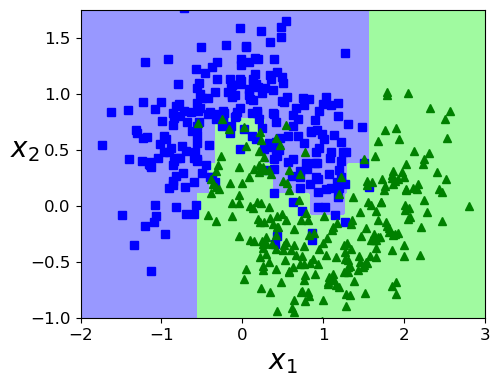

In [34]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff','#a0faa0'])
x0, x1 = np.meshgrid(np.linspace(-2, 3, 200).reshape(-1, 1),
                     np.linspace(-1.5, 2, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
subplots=[121]

ada.fit(X, y)
ypred = ada.predict(X_new)
zz = ypred.reshape(x0.shape)
plt.subplot(subplots[0])
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.axis([-2, 3, -1, 1.75])
plt.show()

# 5.Gradient boosting

- Gradient Boosting is another very popular boosting method.

- As in the Adaboost, we sequentially add predictors to the ensemble.

- The difference is that instead of changing the weights, we try to fit a new predictor to the residual error of the previous predictor.

- The idea is best explained in a regression scenario. It can be, however, generalized to classification.

- Assume that we are given a training set $S=\{(\mathbf{x}_n, y_n)\}_{n=1}^N$.

- We start by fitting a predictor using a base learning algorithm (say, a regression decision tree) to $S$. Assume that the prediction function is $h_1(\mathbf{x})$

- Now, define the residuals of the first model as follows:
    $$\begin{align*}
    \varepsilon^{(1)} := y_n - h_1(\mathbf{x}_n).
    \end{align*}$$

- Next, train a predictor using the base learning algorithm on the errors of the first model, that is, using $\{(\mathbf{x}_n,\varepsilon_n^{(1)})\}_{n=1}^N$ as the training set. Let $h_2(\mathbf{x})$ be the prediction function of this predictor

- What is a good predictor for the response variable $y$ given features $\mathbf{x}$, using both $h_1$ and $h_2$?
    $$\begin{align*}
        y\approx h_1(\mathbf{x}) + h_2(\mathbf{x}).
    \end{align*}$$

- We can now continue improving this prediction. Let us define
    $$
    \begin{align*}
    \varepsilon_n^{(2)} := y_n - h_1(\mathbf{x}_n)-h_2(\mathbf{x}_n).
    \end{align*}$$

- We fit a new predictor using $\{(\mathbf{x}_n,\varepsilon_n^{(2)})\}_{n=1}^N$. Let $h_3(\mathbf{x})$ be the prediction function. We then suggest the following ensemble prediction function bases on $h_1$, $h_2$, and $h_3$
    $$\begin{align*}
        y\approx h_1(\mathbf{x}) + h_2(\mathbf{x}) + h_3(\mathbf{x}).
    \end{align*}


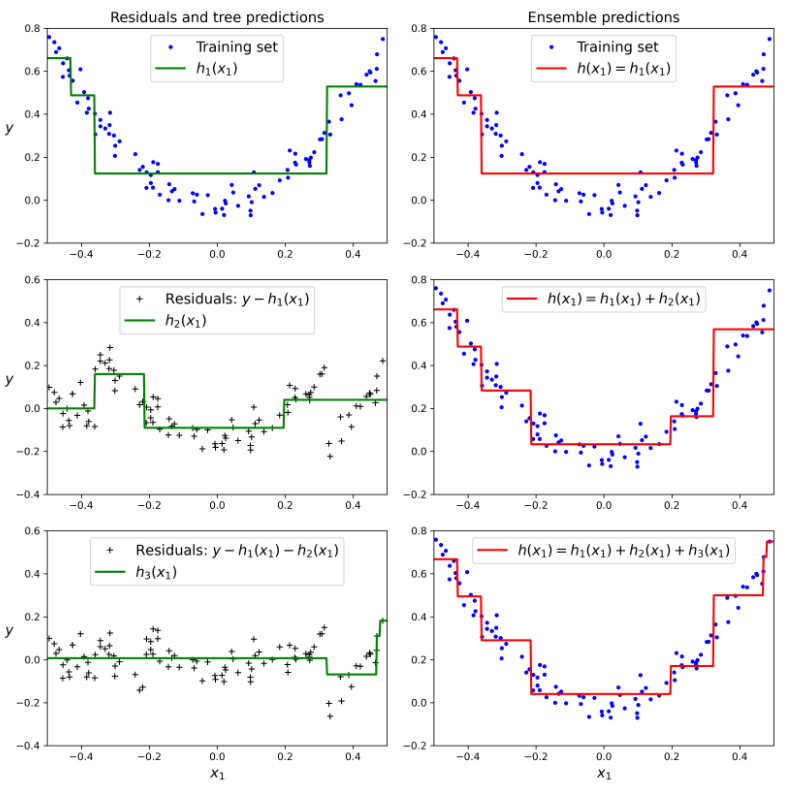

In [35]:
Image("Figs/gradient_boosting_plot.png",width=800)

- A gradient boosting regression algorithm that uses decision trees is called **Gradient Boosted Regression Trees** (GRBT for short).

- The `sklearn.ensemble.GradientBoostingRegressor` implements GBRT.

In [36]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

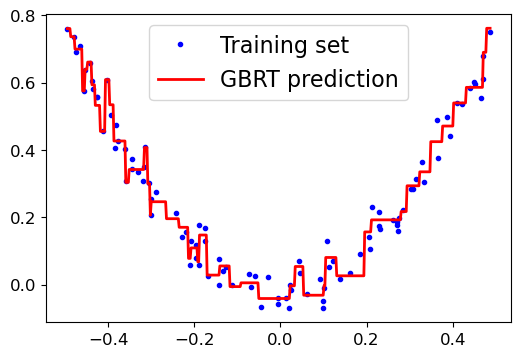

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=20,
                                 learning_rate=1.0,
                                 random_state=42)
gbrt.fit(X, y)
plt.figure(figsize=(6,4))
X_new = np.linspace(min(X), max(X), 500)
ypred = gbrt.predict(X_new)
plt.plot(X, y, "b.", label="Training set")
plt.plot(X_new, ypred, "r-", linewidth=2, label="GBRT prediction")
plt.legend(loc="upper center", fontsize=16)
plt.show()

## 5.1. Regularizing gradient boosting

- As you can see, it is easy to overfit with gradient boosting.

- One way to avoid overfitting, is to apply a learning rate hyperparameter
$$y \approx h_1(\mathbf{x})+\eta h_2(\mathbf{x})+\eta^3h_3(\mathbf{x})+\dots \eta^{k-1}h_k(\mathbf{x})$$

- This method is called **shrinkage**.

- There is a tradeoff between the learning rate and the number of trees. Choosing smaller value for $0<\eta <1$ will make it harder for the ensemble to fit the data, so, we need more trees. By finding a good balance between the learning rate and number of trees, we can find a good bias/variance tradeoff.

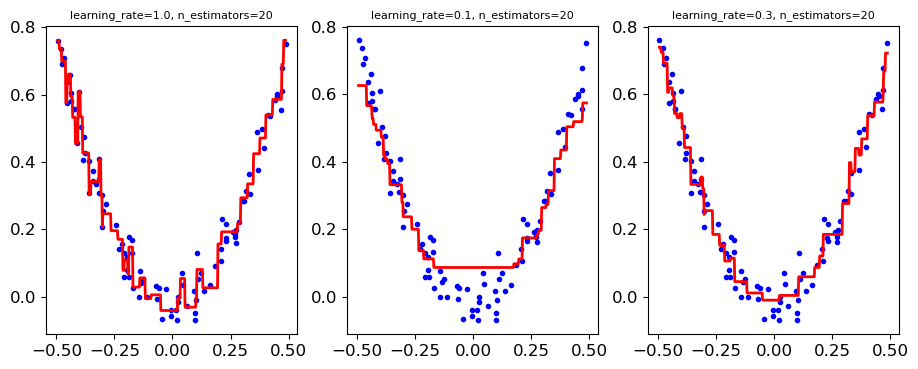

In [38]:
plt.figure(figsize=(11,4))
subplots = [131, 132, 133]
params = [(131, 1.0), (132, 0.1), (133, 0.3)]

for subplot, gam in params:
    plt.subplot(subplot)
    gbrt.set_params(learning_rate=gam,
                    n_estimators=20).fit(X, y)
    X_new = np.linspace(min(X), max(X), 500)
    ypred = gbrt.predict(X_new)
    plt.plot(X, y, "b.")
    plt.plot(X_new, ypred, "r-", linewidth=2)
    plt.title("learning_rate={}, n_estimators={}"
              .format(gbrt.learning_rate, gbrt.n_estimators),
              fontsize=8)
plt.show()

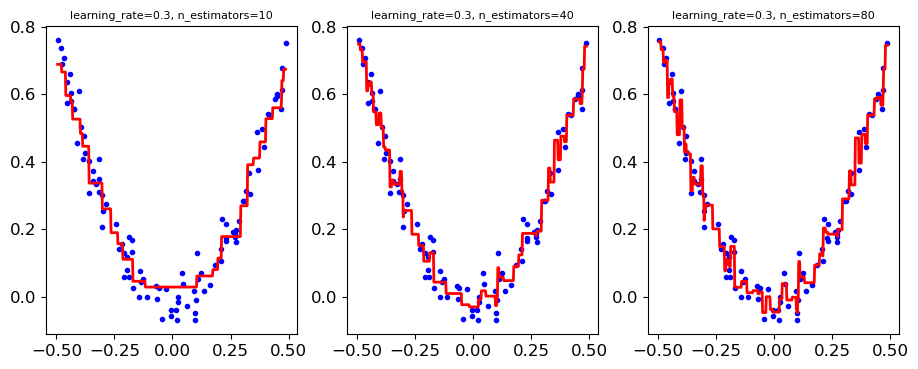

In [39]:
plt.figure(figsize=(11,4))
subplots = [131, 132, 133]
params = [(131, 10), (132, 40), (133, 80)]

for subplot, K in params:
    plt.subplot(subplot)
    gbrt.set_params(learning_rate=0.3,
                    n_estimators=K).fit(X, y)
    X_new = np.linspace(min(X), max(X), 500)
    ypred = gbrt.predict(X_new)
    plt.plot(X, y, "b.")
    plt.plot(X_new, ypred, "r-", linewidth=2)
    plt.title("learning_rate={}, n_estimators={}"
              .format(gbrt.learning_rate, gbrt.n_estimators),
              fontsize=8)
plt.show()


- Now, the question is how to find a good value for `learning_rate` and `n_estimators`.

- We can do a grid search with cross validation.

- A more systematic way is to fix the learning rate (say, to 0.1) and then try to find the value of `n_estimators` that minimizes a validation score.

- Let us start by dividing the data into a training and validation set. We train the model on the training set and report its performance on the validation set.


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

Let us define a new instant of `GradientBoostingRegressor` with `learning_rate=0.1` and `n_estimators` set to a high value, say 120.

In [42]:
gbrt = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.1,
    n_estimators=120, random_state=42
)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

- The method `staged_predict` returns an iterator for the predictions based on a feature vector and using 1 tree, 2 trees, etc.

In [43]:
gbrt.staged_predict(X_val)

<generator object GradientBoostingRegressor.staged_predict at 0x000002433D5062E0>

In [44]:
[ypred for ypred in gbrt.staged_predict(X_val)][:2]

[array([0.25042018, 0.25042018, 0.25042018, 0.25042018, 0.25042018,
        0.25042018, 0.25042018, 0.25042018, 0.30371637, 0.29018668,
        0.25042018, 0.25042018, 0.25042018, 0.25042018, 0.30371637,
        0.25042018, 0.25042018, 0.25042018, 0.30371637, 0.25042018,
        0.25042018, 0.30371637, 0.25042018, 0.28211232, 0.29018668]),
 array([0.23313281, 0.23313281, 0.23313281, 0.23313281, 0.23313281,
        0.23313281, 0.23313281, 0.23313281, 0.33858247, 0.31049451,
        0.26238205, 0.27072802, 0.26238205, 0.23313281, 0.33858247,
        0.23313281, 0.23313281, 0.23313281, 0.33858247, 0.23313281,
        0.23313281, 0.33858247, 0.23313281, 0.29407419, 0.31049451])]

In [46]:
np.array([ypred for ypred in gbrt.staged_predict(X_val)]).shape

(120, 25)

In [47]:
len(X_val)

25

- We can use `staged_predict` to obtain the accuracy scores using any number of trees

In [48]:
from sklearn.metrics import mean_squared_error
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
errors[:10]

[0.03976434066090687,
 0.03301153878946109,
 0.027663386192027795,
 0.023337263188229852,
 0.020390590545872743,
 0.017820174421765502,
 0.015262814214454865,
 0.013228529533567415,
 0.011758450328306618,
 0.010288335529306629]

- Let us find the minimum validation error and the corresponding number of trees.

In [49]:
best_MSE = np.min(errors)
best_n_estimators = np.argmin(errors)+1
print("min MSE: {:.4f}, number of trees: {}"
      .format(best_MSE, best_n_estimators))

min MSE: 0.0027, number of trees: 56


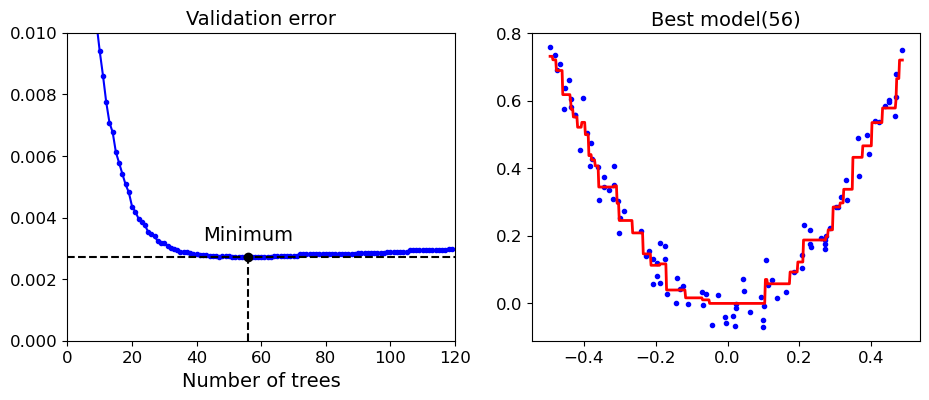

In [50]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, best_MSE], "k--")
plt.plot([0, 120], [best_MSE, best_MSE], "k--")
plt.plot(best_n_estimators, best_MSE, "ko")
plt.text(best_n_estimators, best_MSE*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
gbrt.set_params(n_estimators=best_n_estimators).fit(X, y)
X_new = np.linspace(min(X), max(X), 500)
ypred = gbrt.predict(X_new)
plt.plot(X, y, "b.")
plt.plot(X_new, ypred, "r-", linewidth=2)
plt.title("Best model({})".format(gbrt.n_estimators),
          fontsize=14)
plt.show()

- In the approach above, we first fitted the model with a large number of trees and then figured out what number of trees gives us the best validation score.

- Alternatively, we could incrementally increase the number of trees until the validation score does not improve (say, it does not improve in the last 5 iterations). This strategy is called **early stopping**.

- In the code below, using the argument `warm_start=True` makes Scikit-Learn keep a fitted tree for the next time `.fit` is called. Thus, the model is not retrained, and only a extra tree is added to the ensemble at each iteration.

In [51]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True,
                                 random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [52]:
print("minimum validation MSE: {:.4f}, number of trees: {}"
      .format(min_val_error, gbrt.n_estimators))

minimum validation MSE: 0.0027, number of trees: 61


- Note the number of trees corresponding to the minimum validation MSE is 56 (61 is the number of trees at stopping, and the stopping is after 5 increases in a row).

- Instead of manually coding early stopping, it can also be implemented using the arguments:

    - `validation_fraction` (percentage of the data used for validation),
    - `n_iter_no_change` (number of iterations to wait for a validation score improvement before stopping),
    - `tol` (an improvement must be at least this amount to count as an improvement)

In [54]:
gbrt = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.1, n_estimators=120,
    validation_fraction=0.25, n_iter_no_change=5, tol=0, random_state=50)
gbrt.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=120, n_iter_no_change=5,
                          random_state=50, tol=0, validation_fraction=0.25)

In [58]:
gbrt.n_estimators_

66

- We end our discussion by pointing out that the package `XGBoost` provides a highly efficient Gradient Boosting library.

- To use it, you should install the package (using `pip install xgboost`). See the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/install.html) for detailed instructions.

In [60]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
mean_squared_error(y_val, y_pred)

0.004644479346317078

- You can perform early stopping with `XGBoost` as follows.

In [61]:
xgb.set_params(early_stopping_rounds=2)
xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:0.15232
[1]	validation_0-rmse:0.10690
[2]	validation_0-rmse:0.07868
[3]	validation_0-rmse:0.06385
[4]	validation_0-rmse:0.05656
[5]	validation_0-rmse:0.05486
[6]	validation_0-rmse:0.05394
[7]	validation_0-rmse:0.05556
[8]	validation_0-rmse:0.05682


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [62]:
y_pred = xgb.predict(X_val)
mean_squared_error(y_val, y_pred)

0.0029091166440151123

In [63]:
%timeit XGBRegressor().fit(X_train, y_train)

26 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

7.82 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 5.2 Histogram-based gradient boosting

- Scikit-Learn also provides another GBRT implementation optimized for large datasets, **histogram-based gradient boosting** (HGB), using the class `HistGradientBoostingRegressor` and `HistGradientBoostingClassifier`.

- It works by binning the input features and replacing them with integers.

- This effectively discretizes the features by approximating them with a histogram, which greatly reduces the number of possible splits to consider when training the decision trees.

- The HGB classes allow for categorical features in the training data using OrdinalEncoder and missing values.

- We apply this method to the California Housing dataset in Homework 1.

In [65]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
%timeit hgb_reg.fit(housing, housing_labels)

734 ms ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- The out-of-sammple RMSE is approximately 48,000 without tuning, which is better than the tuned random forest RMSE of approximately 49,000 in Homework 1.

In [67]:
from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
hgb_rmses.mean()

47613.307194169436